## Importing Libraries

In [2]:
import os
import cv2
import csv
import json
import numpy as np
import pandas as pd
import mediapipe as mp
import pickle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "D:\anaconda\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "D:\anaconda\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "D:\anaconda\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "D:\anaconda\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

AttributeError: _ARRAY_API not found

ImportError: numpy.core.multiarray failed to import

## 1. Initializing Landmarks and Data Paths

In [24]:
# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Determine important landmarks for squat
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE"
]

# Paths
DATASET_PATH = "C:/Users/lenovo/Desktop/Exercise_Recognition_AI-main/squat_data_reading.csv"
DATA_DIR = "C:/Users/lenovo/Desktop/Exercise_Recognition_AI-main/PoseData/Squats/data"

In [25]:
# Function to rescale a frame
def rescale_frame(frame, percent=50):
    width = int(frame.shape[1] * percent / 100)
    height = int(frame.shape[0] * percent / 100)
    return cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)

###  1.1 CSV Functions

In [26]:
# Function to initialize CSV with headers
def init_csv(dataset_path: str):
    landmarks = ["id", "stage"]
    for lm in IMPORTANT_LMS:
        landmarks += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]
    if not os.path.exists(dataset_path):  # Create CSV only if it doesn't exist
        with open(dataset_path, mode="w", newline="") as f:
            writer = csv.writer(f)
            writer.writerow(landmarks)
            
# Function to save landmarks to a CSV
def save_landmarks_to_csv(csv_path, frame_id, stage, landmarks):
    with open(csv_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        row = [frame_id, stage]
        row.extend(landmarks)
        writer.writerow(row)
        
        
def save_landmarks_to_csv_perm(csv_path, frame_id, stage, landmarks):
    try:
        # Check if file exists and is accessible
        if not os.access(csv_path, os.W_OK):
            print(f"Permission issue: Cannot write to {csv_path}. Check file permissions.")
            return

        with open(csv_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            row = [frame_id, stage] + landmarks
            writer.writerow(row)
            print(f"Data saved for frame {frame_id}")  # Debugging output

    except PermissionError as e:
        print(f"Permission error: {e}. Check if the file is open in another program.")
    except Exception as e:
        print(f"Unexpected error: {e}")
        
        
def save_landmarks_to_csv_with_skip_error(csv_path, frame_id, stage, landmarks):
    try:
        with open(csv_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            row = [frame_id, stage] + landmarks
            writer.writerow(row)
    except PermissionError as e:
        print(f"PermissionError: {e}. Skipping frame {frame_id}.")

### 1.2 Data Reading Function

In [27]:
def normalize_stage_fraction(stage):
    """
    Normalize the stage value to the range [0, 1] for the current repetition.

    Parameters:
        stage (float): The original stage value.

    Returns:
        float: Normalized fractional progress for the current rep.
    """
    return stage - int(stage)

In [28]:
# Function to process and save landmarks
def process_video_and_labels(video_number, video_path, labels_path, csv_path):
    # Load and filter JSON labels
    with open(labels_path, "r") as file:
        labels = json.load(file)
    frame_stage_map = {frame["frame_numer"]: frame["rep_count"] for frame in labels["images"]}

    # Process video
    cap = cv2.VideoCapture(video_path)

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, image = cap.read()

            if not ret:
                break

            # Get the current frame number
            frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
            frame_id = f"{video_number}.{frame_number}"  # Combine video number and frame number

            # Get the corresponding stage from labels
            stage = normalize_stage_fraction(frame_stage_map.get(frame_number, None))
            if stage is None:
                continue

            # Rescale and process frame
            image = rescale_frame(image, 60)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image_rgb)

            if results.pose_landmarks:
                # Extract landmarks
                landmarks = []
                for lm in IMPORTANT_LMS:
                    keypoint = results.pose_landmarks.landmark[getattr(mp_pose.PoseLandmark, lm)]
                    landmarks.extend([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
                
                # Save landmarks with frame_id
                save_landmarks_to_csv_with_skip_error(csv_path, frame_id, stage, landmarks)

        cap.release()
        cv2.destroyAllWindows()

## 2. Data reading and Preprocessing

### 2.1 Reading Data from Video

In [42]:
# Main logic to process all videos
init_csv(DATASET_PATH)
#counter = 0
video_number = 32
for file_name in sorted(os.listdir(DATA_DIR)):
    if file_name.endswith(".mp4") and int(file_name.split('.')[0]) >= video_number:
        video_path = os.path.join(DATA_DIR, file_name)
        labels_path = os.path.join(DATA_DIR, file_name.replace(".mp4", ".json"))

        if not os.path.exists(labels_path):
            print(f"Missing labels for {file_name}, skipping...")
            continue

        process_video_and_labels(video_number, video_path, labels_path, DATASET_PATH)
        print(f"Video {video_number} processed")
        video_number+=1


Video 32 processed
Video 33 processed
Video 34 processed
Video 35 processed
Video 36 processed
Video 37 processed
Video 38 processed
Video 39 processed
Video 40 processed
Video 41 processed
Video 42 processed
PermissionError: [Errno 13] Permission denied: 'C:/Users/lenovo/Desktop/Exercise_Recognition_AI-main/squat_data_reading.csv'. Skipping frame 43.412.
Video 43 processed
Video 44 processed
Video 45 processed
Video 46 processed
Video 47 processed
Video 48 processed
Video 49 processed
Video 50 processed
Video 51 processed
Video 52 processed
Video 53 processed
Video 54 processed
PermissionError: [Errno 13] Permission denied: 'C:/Users/lenovo/Desktop/Exercise_Recognition_AI-main/squat_data_reading.csv'. Skipping frame 55.360.
Video 55 processed
Video 56 processed
Video 57 processed
Video 58 processed
Video 59 processed
Video 60 processed
Video 61 processed
Video 62 processed
Video 63 processed
Video 64 processed
Video 65 processed
Video 66 processed
Video 67 processed
Video 68 processed

ValueError: invalid literal for int() with base 10: 'squat_3'

### 2.2 Preprocessing Data

In [29]:
# Function to summarize and describe the dataset
def describe_dataset(dataset_path: str, label_column):
    # Load the dataset
    data = pd.read_csv(dataset_path)

    # Print headers
    print(f"Headers: {list(data.columns.values)}\n")

    # Print dataset dimensions
    print(f"Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n")

    # Stage distribution
    if label_column in data.columns:
        print(f"Labels distribution ('{label_column}'): \n{data[label_column].value_counts()}\n")
    else:
        print("'stage' column not found in the dataset.\n")

    # Check for missing values
    missing = data.isnull().sum().sum()  # Total count of missing values
    print(f"Total Missing values: {missing}\n")

    # Check for duplicate rows
    duplicate_rows = data.duplicated().sum()
    print(f"Number of duplicate rows: {duplicate_rows}\n")

    # Check for unique frame IDs
    if 'id' in data.columns:
        unique_ids = data['id'].nunique()
        print(f"Unique frame IDs: {unique_ids} (Out of {data.shape[0]} rows)\n")
    else:
        print("'id' column not found in the dataset. Cannot verify frame uniqueness.\n")

    return data


In [30]:
describe_dataset(DATASET_PATH, "stage")

Headers: ['id', 'stage', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v']

Number of rows: 26342 
Number of columns: 38

Labels distribution ('stage'): 
stage
0.541219    2
0.247844    2
0.054896    2
0.080517    2
0.106835    2
           ..
0.327659    1
0.307343    1
0.286842    1
0.266148    1
0.979023    1
Name: count, Length: 26023, dtype: int64

Total Missing values: 0

Number of duplicate rows: 319

Unique frame IDs: 23601 (Out of 26342 rows)



,id,stage,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,...,right_knee_z,right_knee_v,left_ankle_x,left_ankle_y,left_ankle_z,left_ankle_v,right_ankle_x,right_ankle_y,right_ankle_z,right_ankle_v
0,31.000,0.022214,0.338394,0.358761,-0.358703,0.999954,0.407853,0.455990,-0.094605,0.999947,...,-0.071178,0.980243,0.427654,1.004260,0.066979,0.915504,0.240299,0.999066,0.045828,0.910761
1,31.100,0.044350,0.338397,0.359200,-0.355556,0.999956,0.407942,0.456573,-0.091422,0.999946,...,-0.066597,0.980515,0.421835,1.003670,0.079079,0.915498,0.241750,0.999340,0.053670,0.911100
2,31.200,0.066409,0.338708,0.359280,-0.322020,0.999958,0.408185,0.456571,-0.070669,0.999947,...,-0.066815,0.980434,0.419710,1.001930,0.079861,0.914032,0.243134,0.999055,0.053008,0.909987
3,31.300,0.088394,0.339242,0.360815,-0.314340,0.999961,0.409468,0.458312,-0.061728,0.999950,...,-0.068903,0.980593,0.419086,1.001577,0.078659,0.914185,0.243847,0.998408,0.052610,0.910136
4,31.400,0.110305,0.339986,0.367960,-0.324068,0.999964,0.410391,0.461782,-0.054860,0.999953,...,-0.070510,0.980774,0.417762,1.001352,0.078458,0.914685,0.243830,0.998398,0.053457,0.910494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26337,99.402,0.850477,0.649422,0.371499,-0.470373,0.999937,0.709163,0.456696,-0.179972,0.999914,...,-0.049225,0.995055,0.694286,0.916173,0.314780,0.976712,0.541748,0.931209,0.106592,0.989132
26338,99.403,0.882562,0.648836,0.370869,-0.463138,0.999943,0.708096,0.456199,-0.164427,0.999918,...,-0.051518,0.995243,0.693901,0.916179,0.321559,0.977436,0.542396,0.934351,0.099053,0.989549
26339,99.404,0.914685,0.647789,0.373786,-0.467413,0.999948,0.707607,0.456869,-0.164916,0.999923,...,-0.047122,0.995455,0.693812,0.915975,0.320243,0.978364,0.543076,0.934982,0.098935,0.990003
26340,99.405,0.946841,0.645754,0.378304,-0.489407,0.999953,0.707145,0.457120,-0.181655,0.999926,...,-0.050408,0.995564,0.693190,0.916046,0.285107,0.978644,0.543162,0.935713,0.088838,0.990199


In [31]:
def clean_and_normalize_dataset(dataset_path: str, output_path: str):
    data = pd.read_csv(dataset_path)
    
    # Remove duplicates by 'id'
    if 'id' in data.columns:
        data = data.drop_duplicates(subset='id', keep='first')
        print(f"Removed duplicates. Remaining rows: {data.shape[0]}")
    else:
        print("'id' column not found in the dataset. Skipping duplicate removal.")
    
    # Normalize 'stage' values
    if 'stage' in data.columns:
        data['stage_normalized'] = data['stage'].apply(lambda x: round(float(x), 2))
        print("Normalized 'stage' values and added new column 'stage_normalized'.")
    else:
        print("'stage' column not found in the dataset. Skipping normalization.")
    
    # Save the cleaned and updated dataset
    data.to_csv(output_path, index=False)
    print(f"Cleaned and normalized dataset saved to {output_path}")

In [32]:
os.makedirs("data_csvs", exist_ok=True)
UPDATE_DATA_PATH = "data_csvs/squat_normalized_data.csv"
clean_and_normalize_dataset(DATASET_PATH, UPDATE_DATA_PATH)

Removed duplicates. Remaining rows: 23601
Normalized 'stage' values and added new column 'stage_normalized'.
Cleaned and normalized dataset saved to data_csvs/squat_normalized_data.csv


In [33]:
describe_dataset(UPDATE_DATA_PATH, "stage_normalized")

Headers: ['id', 'stage', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'stage_normalized']

Number of rows: 23601 
Number of columns: 39

Labels distribution ('stage_normalized'): 
stage_normalized
0.70    264
0.07    255
0.58    254
0.95    253
0.54    252
       ... 
0.51    217
0.96    213
0.68    210
1.00    119
0.00    106
Name: count, Length: 101, dtype: int64

Total Missing values: 0

Number of duplicate rows: 0

Unique frame IDs: 23601 (Out of 23601 rows)



,id,stage,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,...,right_knee_v,left_ankle_x,left_ankle_y,left_ankle_z,left_ankle_v,right_ankle_x,right_ankle_y,right_ankle_z,right_ankle_v,stage_normalized
0,31.000,0.022214,0.338394,0.358761,-0.358703,0.999954,0.407853,0.455990,-0.094605,0.999947,...,0.980243,0.427654,1.004260,0.066979,0.915504,0.240299,0.999066,0.045828,0.910761,0.02
1,31.100,0.044350,0.338397,0.359200,-0.355556,0.999956,0.407942,0.456573,-0.091422,0.999946,...,0.980515,0.421835,1.003670,0.079079,0.915498,0.241750,0.999340,0.053670,0.911100,0.04
2,31.200,0.066409,0.338708,0.359280,-0.322020,0.999958,0.408185,0.456571,-0.070669,0.999947,...,0.980434,0.419710,1.001930,0.079861,0.914032,0.243134,0.999055,0.053008,0.909987,0.07
3,31.300,0.088394,0.339242,0.360815,-0.314340,0.999961,0.409468,0.458312,-0.061728,0.999950,...,0.980593,0.419086,1.001577,0.078659,0.914185,0.243847,0.998408,0.052610,0.910136,0.09
4,31.400,0.110305,0.339986,0.367960,-0.324068,0.999964,0.410391,0.461782,-0.054860,0.999953,...,0.980774,0.417762,1.001352,0.078458,0.914685,0.243830,0.998398,0.053457,0.910494,0.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23596,99.402,0.850477,0.649422,0.371499,-0.470373,0.999937,0.709163,0.456696,-0.179972,0.999914,...,0.995055,0.694286,0.916173,0.314780,0.976712,0.541748,0.931209,0.106592,0.989132,0.85
23597,99.403,0.882562,0.648836,0.370869,-0.463138,0.999943,0.708096,0.456199,-0.164427,0.999918,...,0.995243,0.693901,0.916179,0.321559,0.977436,0.542396,0.934351,0.099053,0.989549,0.88
23598,99.404,0.914685,0.647789,0.373786,-0.467413,0.999948,0.707607,0.456869,-0.164916,0.999923,...,0.995455,0.693812,0.915975,0.320243,0.978364,0.543076,0.934982,0.098935,0.990003,0.91
23599,99.405,0.946841,0.645754,0.378304,-0.489407,0.999953,0.707145,0.457120,-0.181655,0.999926,...,0.995564,0.693190,0.916046,0.285107,0.978644,0.543162,0.935713,0.088838,0.990199,0.95


### 2.3 Plotting Graph

In [34]:
def plot_normalized_stage_distribution(dataset_path: str):
    # Read the dataset
    data = pd.read_csv(dataset_path)
    
    # Group data by normalized_stage and count occurrences
    stage_counts = data['stage_normalized'].value_counts().sort_index()
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(stage_counts.index, stage_counts.values, marker='o', color='skyblue', linestyle='-')

    # Customize the plot
    plt.title("Distribution of Normalized Stages", fontsize=16)
    plt.xlabel("Normalized Stage (2 Decimal Places)", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

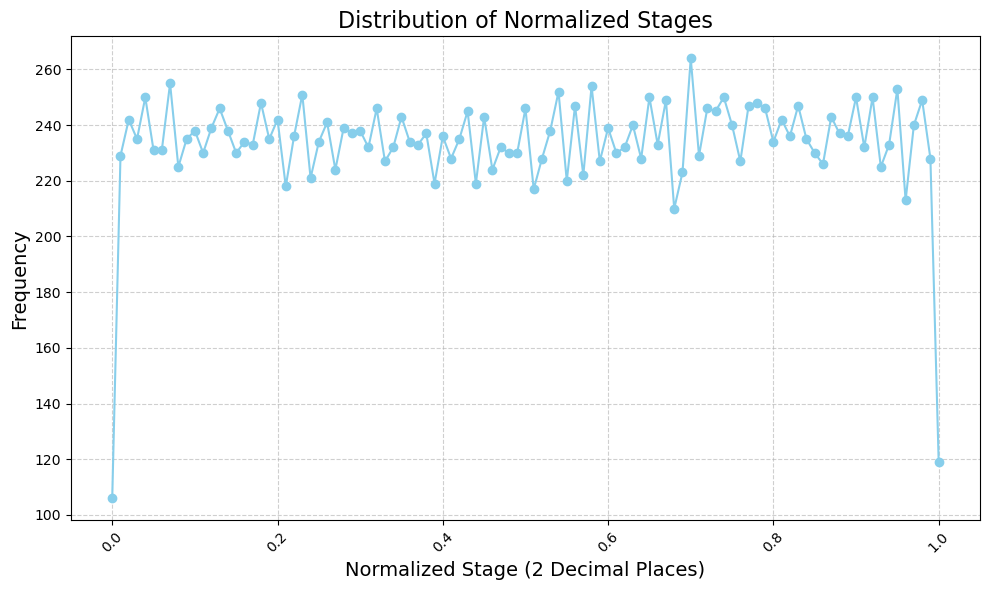

In [35]:
plot_normalized_stage_distribution(UPDATE_DATA_PATH)

# 3. Train Custom Model

**3.1 Extracting Features**

In [53]:
# Load dataset
data = pd.read_csv(UPDATE_DATA_PATH)

# Features and target
X = data.filter(regex='_(x|y|z|v)$')  # Select only coordinate columns
y = data['stage_normalized']

In [54]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**3.2 Train ML Model**

In [55]:
# Algorithms for regression
regressors = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest Regressor", RandomForestRegressor()),
    ("Support Vector Regressor", SVR(kernel='rbf'))
]

models = {}
regression_results = []

for name, model in regressors:
    # Train the model
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Predict on the test set
    y_pred = trained_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    regression_results.append((name, round(mse, 4), round(r2, 4)))

# Display results
results_df = pd.DataFrame(regression_results, columns=["Model", "Mean Squared Error", "R2 Score"])
print(results_df)

                      Model  Mean Squared Error  R2 Score
0         Linear Regression              0.0786    0.0566
1   Random Forest Regressor              0.0195    0.7659
2  Support Vector Regressor              0.0850   -0.0211


**3.3 Saving the Models**

In [56]:
# Directory to save models
os.makedirs("saved_models", exist_ok=True)

# Save each trained model
for name, model in models.items():
    model_path = f"saved_models/{name.replace(' ', '_')}.pkl"
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model {name} saved to {model_path}")

Model Linear Regression saved to saved_models/Linear_Regression.pkl
Model Random Forest Regressor saved to saved_models/Random_Forest_Regressor.pkl
Model Support Vector Regressor saved to saved_models/Support_Vector_Regressor.pkl


## Training Alternate Model

In [36]:
# Function to calculate the angle between three 3D points
def calculate_angle(A, B, C):
    """
    Calculate the angle between three points A, B, and C.
    
    A, B, C: Tuples or lists representing 3D coordinates of points (x, y, z).
    Returns: Angle in degrees between vector AB and BC.
    """
    # Convert points to numpy arrays for vector operations
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    
    # Calculate vectors AB and BC
    AB = A - B
    BC = C - B
    
    # Calculate the dot product
    dot_product = np.dot(AB, BC)
    
    # Calculate the magnitudes (lengths) of the vectors
    mag_AB = np.linalg.norm(AB)
    mag_BC = np.linalg.norm(BC)
    
    # Calculate the cosine of the angle
    cos_theta = dot_product / (mag_AB * mag_BC)
    
    # Ensure the value is within the valid range for arccos to avoid errors due to floating point precision
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Calculate the angle in radians and convert to degrees
    angle = np.degrees(np.arccos(cos_theta))
    
    return angle

In [37]:
# Load your CSV file into a DataFrame
# Directory to save models
os.makedirs("data_csvs", exist_ok=True)
UPDATE_DATA_PATH = "data_csvs/squat_normalized_data.csv"
df = pd.read_csv(UPDATE_DATA_PATH)

# Create empty lists to store the calculated angles
left_hip_angles = []
right_hip_angles = []
left_knee_angles = []
right_knee_angles = []

# Now you can perform the angle calculations
for index, row in df.iterrows():
    # Extract coordinates for left and right hip, knee, and shoulder
    left_hip = (row['left_hip_x'], row['left_hip_y'], row['left_hip_z'])
    left_knee = (row['left_knee_x'], row['left_knee_y'], row['left_knee_z'])
    left_ankle = (row['left_ankle_x'], row['left_ankle_y'], row['left_ankle_z'])
    left_shoulder = (row['left_shoulder_x'], row['left_shoulder_y'], row['left_shoulder_z'])

    right_hip = (row['right_hip_x'], row['right_hip_y'], row['right_hip_z'])
    right_knee = (row['right_knee_x'], row['right_knee_y'], row['right_knee_z'])
    right_ankle = (row['right_ankle_x'], row['right_ankle_y'], row['right_ankle_z'])
    right_shoulder = (row['right_shoulder_x'], row['right_shoulder_y'], row['right_shoulder_z'])

    # Calculate hip angles (left and right) - Angle between shoulder, hip, and knee
    left_hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
    right_hip_angle = calculate_angle(right_shoulder, right_hip, right_knee)

    # Calculate knee angles (left and right) - Angle between hip, knee, and ankle
    left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
    right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
    
    # Append the calculated angles to the lists
    left_hip_angles.append(left_hip_angle)
    right_hip_angles.append(right_hip_angle)
    left_knee_angles.append(left_knee_angle)
    right_knee_angles.append(right_knee_angle)

# Add the calculated angles to the DataFrame
df['left_hip_angle'] = left_hip_angles
df['right_hip_angle'] = right_hip_angles
df['left_knee_angle'] = left_knee_angles
df['right_knee_angle'] = right_knee_angles

# Save the updated DataFrame back to a CSV file
df.to_csv(UPDATE_DATA_PATH, index=False)
    

In [54]:
# Load dataset
data = pd.read_csv(UPDATE_DATA_PATH)

# Features and target
X = data.filter(regex='_(angle|x|y|z)$')  # Select both angle and coordinate columns
y = data['stage_normalized']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [56]:
# Algorithms for regression
regressors = [
    ("Linear Regression", LinearRegression()),
    ("Random Forest Regressor", RandomForestRegressor()),
    ("Support Vector Regressor", SVR(kernel='rbf'))
]

models = {}
regression_results = []

for name, model in regressors:
    # Train the model
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Predict on the test set
    y_pred = trained_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    regression_results.append((name, round(mse, 4), round(r2, 4)))

# Display results
results_df = pd.DataFrame(regression_results, columns=["Model", "Mean Squared Error", "R2 Score"])
print(results_df)

                      Model  Mean Squared Error  R2 Score
0         Linear Regression              0.0799    0.0407
1   Random Forest Regressor              0.0251    0.6987
2  Support Vector Regressor              0.0690    0.1713


In [57]:
# Directory to save models
os.makedirs("saved_angle_models", exist_ok=True)

# Save each trained model
for name, model in models.items():
    model_path = f"saved_angle_models/{name.replace(' ', '_')}.pkl"
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model {name} saved to {model_path}")

Model Linear Regression saved to saved_angle_models/Linear_Regression.pkl
Model Random Forest Regressor saved to saved_angle_models/Random_Forest_Regressor.pkl
Model Support Vector Regressor saved to saved_angle_models/Support_Vector_Regressor.pkl


# 4. Testing Model in Real Time

In [12]:
def extract_important_keypoints(results) -> list:
    landmarks = results.pose_landmarks.landmark

    data = []
    for lm in IMPORTANT_LMS:
        keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
        data.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
    
    return np.array(data).flatten().tolist()

headers = []

for lm in IMPORTANT_LMS:
    headers += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

In [13]:
# Example of loading a saved model
with open("saved_models/Random_Forest_Regressor.pkl", 'rb') as file:
    loaded_model = pickle.load(file)

In [14]:
# Initialize counter variables for reps
rep_counter = 0
previous_stage = None  # Store previous stage to detect transitions
threshold_down = 0.4   # Adjust based on squat depth
threshold_up = 0.7     # Adjust based on standing height

In [16]:
# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

cap = cv2.VideoCapture(0)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            break

        # Convert image to RGB (Mediapipe requires RGB input)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Process the image to get pose landmarks
        results = pose.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw pose landmarks
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                      mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=2), 
                                      mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=1))
            
            try:
                # Extract keypoints
                row = extract_important_keypoints(results)

                # Ensure the row matches expected input size
                if len(row) == len(headers):
                    # Convert keypoints to DataFrame
                    X = pd.DataFrame([row], columns=headers)
                    
                    # Predict normalized squat stage
                    predicted_stage = loaded_model.predict(X)[0]

                    # Display the prediction
                    cv2.rectangle(image, (0, 0), (500, 60), (245, 117, 16), -1)
                    cv2.putText(image, f"Predicted Stage: {predicted_stage:.2f}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)
                
                else:
                    print(f"Feature mismatch: Expected {len(headers)}, but got {len(row)}")

            except Exception as e:
                print(f"Error during prediction: {e}")

        # Show the output frame
        cv2.imshow("Squat Stage Prediction", image)

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
D:\anaconda\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: Symbol

In [11]:
def get_csv_headers(file_path):
    with open(file_path, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        headers = next(reader)  # Get the first row as headers
    return headers

# Example usage
csv_file = UPDATE_DATA_PATH  # Replace with your CSV file path
headers = get_csv_headers(csv_file)
print(headers)

['id', 'stage', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'stage_normalized']
